Importing Important libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import torch
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Defining Function to read data

In [ ]:
labels = ["NORMAL" ,"PNEUMONIA"]
img_size = 300
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if class_num!=0: # naming class 0 for Normal
                if "virus" in img.split("_") or "viral" in img.split("_"):
                    class_num=2 # naming class 2 for Viral Pneumonia
                else:
                    class_num=1 # naming class 1 for Bacterial Pneumonia
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uploading Data

In [ ]:
# extracting data from zip file saved in drive
!unzip -u "/content/drive/MyDrive/major_project_dataset.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/dataset/train/NORMAL/IM-0409-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0410-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0411-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0413-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0414-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0416-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0417-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0419-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0420-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0421-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0423-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0424-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0425-0001.jpeg  
  inflating: /content/data/dataset/train/NORMAL/IM-0427-0001.jpeg

In [ ]:
# loading dataset to local memory
train = get_training_data("/content/data/dataset/train")
test = get_training_data("/content/data/dataset/test")
val = get_training_data("/content/data/dataset/val")

<ipython-input-2-1a3028e01350>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
# analysing training dataset
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    elif(i[1]==1):
        l.append("Bacterial")
    else:
        l.append("Viral")
sns.set_style('darkgrid')
sns.countplot(l)      

ValueError: ignored

In [ ]:
# deleting 800 random bacterial photos
lst=[]
for n,i in enumerate(train):
    if i[1]== 1:
        lst.append(n)
        
old_train=train
train=np.delete(old_train,random.sample(lst,800),axis=0)

In [ ]:
# analysing training dataset
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    elif(i[1]==1):
        l.append("Bacterial")
    else:
        l.append("Viral")
sns.set_style('darkgrid')
sns.countplot(l)      

Text(0.5, 1.0, 'PNEUMONIA')

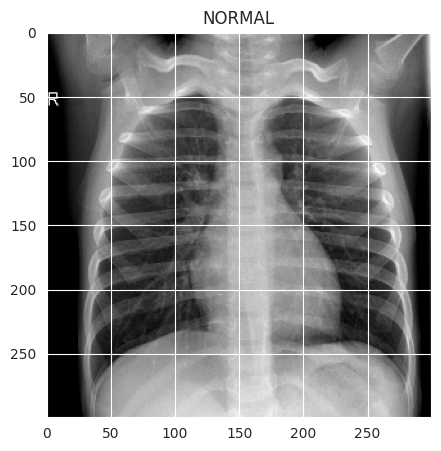

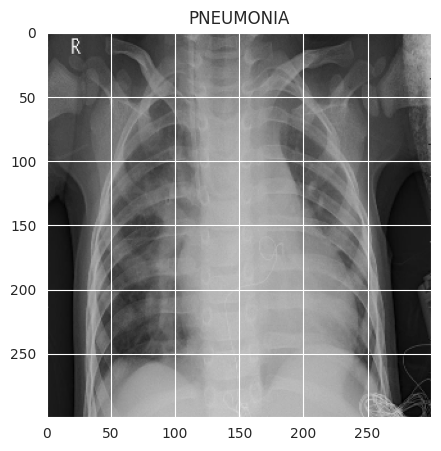

In [ ]:
#ploting X-ray images
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title("NORMAL")

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title("PNEUMONIA")

Pre-processing data

In [ ]:
#formating data to be model ready
train_x=list(train[:,0])
train_y=np.array(list(train[:,1]))

test_x=list(test[:,0])
test_y=np.array(list(test[:,1]))

val_x=list(val[:,0])
val_y=np.array(list(val[:,1]))

In [ ]:
#converting class to 1-hot encoding
y_train=np.zeros((train_y.size,train_y.max()+1))
y_train[np.arange(train_y.size),train_y]=1

y_test=np.zeros((test_y.size,test_y.max()+1))
y_test[np.arange(test_y.size),test_y]=1

y_val=np.zeros((val_y.size,val_y.max()+1))
y_val[np.arange(val_y.size),val_y]=1

In [ ]:
#Normalising the data
train_x = np.array(train_x) / 255
test_x = np.array(test_x) / 255
val_x = np.array(val_x) / 255

train_x=train_x.reshape(-1, img_size, img_size, 1)
test_x=test_x.reshape(-1, img_size, img_size, 1)
val_x=val_x.reshape(-1, img_size, img_size, 1)

Data Augmentation

In [ ]:
#using image generator to generate more data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

Defining different layers of the model

In [ ]:
from keras.constraints import unit_norm
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer="he_normal",kernel_constraint=unit_norm() , input_shape = (300,300,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_constraint=unit_norm()))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_constraint=unit_norm()))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_constraint=unit_norm()))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#history = model.fit(train_x,y_train, batch_size = 32 ,epochs = 12,validation_data = (val_x, y_val) ,callbacks = [learning_rate_reduction] )
history = model.fit(datagen.flow(train_x,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(val_x, y_val) ,callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , model.evaluate(test_x,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(test_x,y_test)[1]*100 , "%")

In [ ]:
model.save('my_model.h5')

Analysis of model training

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

Importing trained model

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5')

print("Loss of the model is - " , trained_model.evaluate(test_x,y_test)[0])
print("Accuracy of the model is - " , trained_model.evaluate(test_x,y_test)[1]*100 , "%")

20/20 [==============================] - 9s 47ms/step - loss: 0.7231 - accuracy: 0.8083
Loss of the model is -  0.7231157422065735
20/20 [==============================] - 1s 27ms/step - loss: 0.7231 - accuracy: 0.8083
Accuracy of the model is -  80.83066940307617 %


Trying on a random image from Internet

In [ ]:
from PIL import Image
import requests
from io import BytesIO

url="https://img.medscapestatic.com/pi/meds/ckb/54/16954tn.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.save("/content/test_img.jpg")

1/1 [==============================] - 0s 319ms/step
[1.8559845e-08, 0.89509207, 0.10490791]


Text(0.5, 1.0, 'Bacterial Pneumonia')

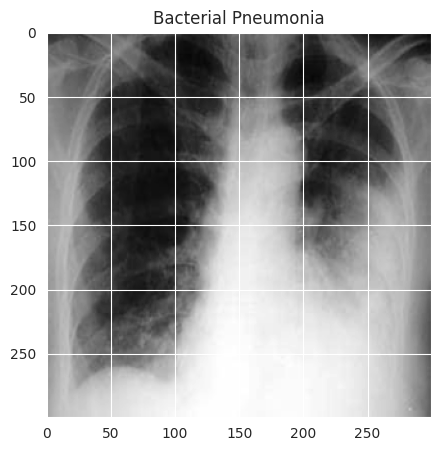

In [ ]:
class_map={0:"Normal",1:"Bacterial Pneumonia",2:"Viral Pneumonia"}
img_size=300
img_arr = cv2.imread("/content/test_img.jpg",cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
img=resized_arr/ 255
img=img.reshape(-1, img_size, img_size, 1)

pred=list(trained_model.predict(img)[0])
print(pred)

plt.figure(figsize = (5,5))
plt.imshow(resized_arr, cmap='gray')
plt.title(class_map[pred.index(max(pred))])

In [ ]:
from sklearn.metrics import classification_report
pred=list(trained_model.predict(test_x))
y_pred=[]
for p in pred:
  p=list(p)
  y_pred.append(p.index(max(p)))
print(y_pred)
print(class_map.values())
report = classification_report(test_y, y_pred, labels=[0,1,2], target_names=class_map.values())
print(report)

20/20 [==============================] - 1s 28ms/step
[0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 

Axes(0.125,0.11;0.62x0.77)


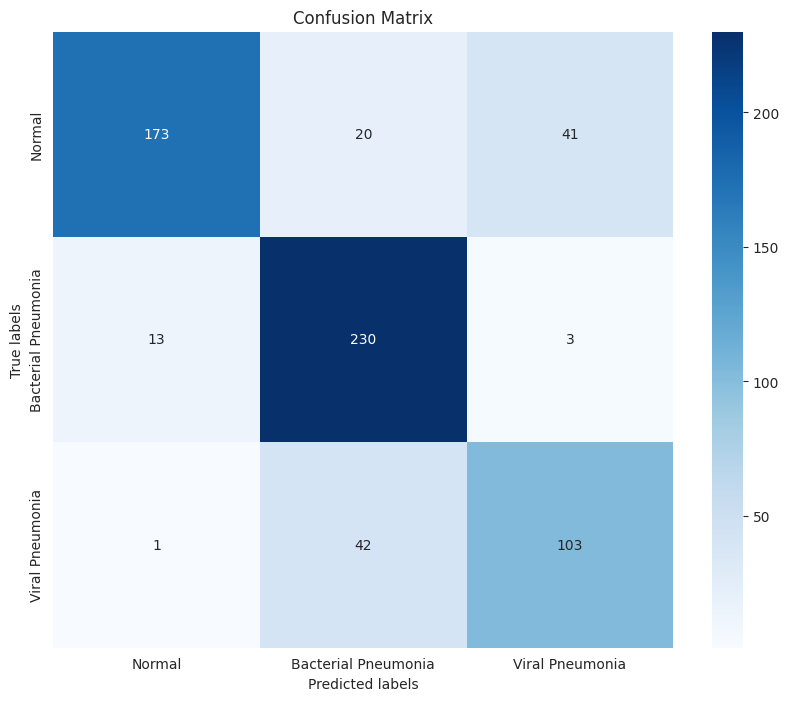

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

cf=confusion_matrix(test_y,y_pred,labels=[0,1,2])
f = plt.figure(figsize=(10,8))

ax= f.add_subplot()
sns.heatmap(cf, annot=True,fmt='g',cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_map.values()); ax.yaxis.set_ticklabels(class_map.values());

print(ax)